In [1]:
%matplotlib inline
import pandas as pd 
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

In [2]:
def stringToInt(var):
    try:
        var = np.int16(var)
        return var
    except Exception:
        if var == 'R':
            return np.int16(130)# Setting a arbituary hight value for Forclosed home
        else:
            return np.int16(-1)

def stringToFloat(var):
    try:
        var = np.float32(var)
        return var
    except Exception:
        return np.float32(0)

def fillFlag(var):
    try:
        var=np.char(var)
        return var
    except Exception:
        return np.char('F')



### Data file containing loan origination information for Year 1999
  This data is made available from Freddie Mae 
  http://www.freddiemac.com/news/finance/sf_loanlevel_dataset.html
  
  For every year the loan contains ziped file for each quater
    example : historical_data1_Q11999.zip 
  
  Each zipped file has two dataset in tab seperated txt file
    1. Single Family Loan-Level Dataset.
    2. Monthly Performance Dataset
    
  Single Family Loan-Level Dataset  has data at the time of loan was originated
  
        ● Credit Score
        ● First Time buyer flag
        ● Mortgage Insurance Percentage
        ● Occupancy Status
        ● Debt to Income Ratio(DTI Ratio)
        ● ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)  
        ● ORIGINAL UPB
        ● ORIGINAL LOAN-TO-VALUE (LTV)  
        ● Loan Sequence Number
   
  
  Monthly Performance Dataset has monthly perormance of data from date of origination to end of 2015.
  
        ● Loan Sequence Number
        ● Monthly Reporting Period (YYYYMM)
        ● Current UPB
        ● Current Loan Delinquency Status
        ● Loan Age
        ● Remaining months of maturity
        ● Repurchase Flag
        ● MODIFICATION FLAG
        ● Zero Balance Code
        ● ZERO BALANCE EFFECTIVE DATE
        ● CURRENT INTEREST RATE
        ● CURRENT DEFERRED UPB



#### Getting Loan Level Data with required conversion functions

In [3]:
fields_Origin = ['CREDIT SCORE','FIRST TIME HOMEBUYER FLAG','MORTGAGE INSURANCE PERCENTAGE','CLTV','DTI Ratio',
          'ORIGINAL UPB','ORIGINAL LTV','ORIGINAL INTEREST RATE' ,'LOAN SEQUENCE NUMBER']    #9
fData=pd.read_csv('data/historical_data1_Q11999/historical_data1_Q11999.txt','|',index_col=None, encoding='utf-8',low_memory=False
                 ,usecols=fields_Origin,converters={'CREDIT SCORE':stringToInt,
                                                     'DTI Ratio':stringToFloat,
                                                      'CLTV':stringToFloat})
len(fData)

392776

#### Getting Montly Loan Data

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m')
fields_Month=['LOAN SEQUENCE NUMBER','MONTHLY REPORTING PERIOD','CURRENT ACTUAL UPB','CURRENT LOAN DELINQUENCY STATUS',
              'REMAINING MONTHS TO LEGAL MATURITY','REPURCHASE FLAG','MODIFICATION FLAG',
              'ZERO BALANCE CODE','ZERO BALANCE EFFECTIVE DATE','CURRENT INTEREST RATE','CURRENT DEFERRED UPB']
reader=pd.read_csv('data/historical_data1_Q11999/historical_data1_time_Q11999.txt','|',
                   index_col=None, parse_dates=['MONTHLY REPORTING PERIOD'],
                   date_parser=dateparse,encoding='utf-8',low_memory=False,chunksize=10000
                  ,usecols=fields_Month,converters={'CURRENT ACTUAL UPB':stringToFloat,
                                                    'CURRENT LOAN DELINQUENCY STATUS':stringToInt})


#Get dataframe from chunks
df = pd.concat(chunk for chunk in reader)

#Fill missing data
df['REPURCHASE FLAG'].fillna('F', inplace=True)
df['MODIFICATION FLAG'].fillna('N', inplace=True)
df['ZERO BALANCE CODE'].fillna('00', inplace=True)
df['ZERO BALANCE EFFECTIVE DATE'].fillna('000000', inplace=True)

df.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 22227548 entries, 0 to 7547
Data columns (total 11 columns):
LOAN SEQUENCE NUMBER                  object
MONTHLY REPORTING PERIOD              datetime64[ns]
CURRENT ACTUAL UPB                    float64
CURRENT LOAN DELINQUENCY STATUS       int64
REMAINING MONTHS TO LEGAL MATURITY    int64
REPURCHASE FLAG                       object
MODIFICATION FLAG                     object
ZERO BALANCE CODE                     object
ZERO BALANCE EFFECTIVE DATE           object
CURRENT INTEREST RATE                 float64
CURRENT DEFERRED UPB                  float64
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 2.0+ GB


In [5]:
df2=df.sort_values(by='CURRENT LOAN DELINQUENCY STATUS',ascending=False)
print (df2['MONTHLY REPORTING PERIOD'].max())
print (df2['MONTHLY REPORTING PERIOD'].min())
print (df2['CURRENT LOAN DELINQUENCY STATUS'].max())

2015-12-01 00:00:00
1999-02-01 00:00:00
130


In [6]:
#Calculate two new columns 
df['year']=df['MONTHLY REPORTING PERIOD'].dt.year
df['quarter']=df['MONTHLY REPORTING PERIOD'].dt.quarter
df.head()

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,REMAINING MONTHS TO LEGAL MATURITY,REPURCHASE FLAG,MODIFICATION FLAG,ZERO BALANCE CODE,ZERO BALANCE EFFECTIVE DATE,CURRENT INTEREST RATE,CURRENT DEFERRED UPB,year,quarter
0,F199Q1000001,2002-05-01,171982.437500,0,328,F,N,00,000000,6.3,0.0,2002,2
1,F199Q1000001,2002-06-01,171571.390625,0,327,F,N,00,000000,6.3,0.0,2002,2
2,F199Q1000001,2002-07-01,171158.328125,0,326,F,N,00,000000,6.3,0.0,2002,3
3,F199Q1000001,2002-08-01,170742.890625,0,325,F,N,00,000000,6.3,0.0,2002,3
4,F199Q1000001,2002-09-01,170325.171875,0,324,F,N,00,000000,6.3,0.0,2002,3


#### Removing Loan data with no credit score

In [7]:
print (len(fData))
fDataClean=fData[fData['CREDIT SCORE']>0]
print (len(fDataClean))

392776
391229


#### Removing invalid data (Missing CURRENT LOAN DELINQUENCY STATUS) and Forclosed data out.


In [8]:
print (len(df))
dfClean=df[df['CURRENT LOAN DELINQUENCY STATUS'] >-1]
print (len(dfClean))
dfClean=dfClean[dfClean['CURRENT LOAN DELINQUENCY STATUS'] <130]
print (len(dfClean))

22227548
22227548
22221286


### Merging  Loan Origination with Monthly datasets 

In [9]:

dfMonthly = pd.merge(dfClean,fDataClean,on='LOAN SEQUENCE NUMBER')
dfMonthly.head()
print (len(dfMonthly))

22124867


### Slicing and peeking into dataset

In [10]:
df1=dfMonthly[['LOAN SEQUENCE NUMBER','CREDIT SCORE','CURRENT LOAN DELINQUENCY STATUS']]
df1.head(20)

,LOAN SEQUENCE NUMBER,CREDIT SCORE,CURRENT LOAN DELINQUENCY STATUS
0,F199Q1000001,751,0
1,F199Q1000001,751,0
2,F199Q1000001,751,0
3,F199Q1000001,751,0
4,F199Q1000001,751,0
5,F199Q1000001,751,0
6,F199Q1000001,751,0
7,F199Q1000002,733,0
8,F199Q1000002,733,0
9,F199Q1000002,733,0


### Understanding key values of combined dataset

In [11]:
df2=df1.sort_values(by='CURRENT LOAN DELINQUENCY STATUS',ascending=False)
df2.head(20)

,LOAN SEQUENCE NUMBER,CREDIT SCORE,CURRENT LOAN DELINQUENCY STATUS
3743777,F199Q1068505,742,128
17408608,F199Q1314043,695,100
17408607,F199Q1314043,695,99
17408606,F199Q1314043,695,98
17408605,F199Q1314043,695,97
17408604,F199Q1314043,695,96
17408603,F199Q1314043,695,95
17408602,F199Q1314043,695,94
17408601,F199Q1314043,695,93
17408600,F199Q1314043,695,92


### Grouping data for each loan.  Total number of unique loans

In [12]:
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df3=df2.reset_index()
df3.head()

len(df3)

391192

#### Getting final clean dataset for analysis

In [21]:
dfWithG=dfMonthly[['LOAN SEQUENCE NUMBER','MONTHLY REPORTING PERIOD','CURRENT ACTUAL UPB','CURRENT LOAN DELINQUENCY STATUS',
              'REMAINING MONTHS TO LEGAL MATURITY','REPURCHASE FLAG','MODIFICATION FLAG',
              'ZERO BALANCE CODE','CURRENT INTEREST RATE','CURRENT DEFERRED UPB','year','quarter',
              'CREDIT SCORE','FIRST TIME HOMEBUYER FLAG','MORTGAGE INSURANCE PERCENTAGE','CLTV','DTI Ratio']]

## Checking the Correlation between Loan Delinquency and Other features
   
     1. The column CURRENT LOAN DELINQUENCY STATUS is measure of no of days a loan is behind , hence non-performing.
     2. The following exercise plots the values of a feature against the CURRENT LOAN DELINQUENCY STATUS to see the   relationships.

In [23]:
import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [24]:
def groupInterestRate(var):
    if 0< var <1:
        return 0.5
    if 1< var <2:
        return 1.5
    if 2< var <3:
        return 2.5
    if 3< var <4:
        return 3.5
    if 4< var <5:
        return 4.5
    if 5< var <6:
        return 5.5
    if 6< var <7:
        return 6.5
    if 7< var <8:
        return 7.5
    if 8< var <9:
        return 9.5
    else:
        return 10
        

In [25]:
def groupDTIRatio(var):
    if 0< var <10:
        return 5
    if 10< var <20:
        return 15
    if 20< var <30:
        return 25
    if 30< var <40:
        return 35
    if 40< var <50:
        return 45
    if 50< var <60:
        return 55
    if 60< var <70:
        return 65
    if 70< var <80:
        return 75
    if 80< var <90:
        return 85
    if 90< var <100:
        return 95
    else:
        return 100

### Get data for a given year quarter 
     The loan performance data is for each month. Our aim is to measure the loan performance in a given quater.
     So we group data in quater.One row for quater

In [26]:
dfWithG=dfWithG[(dfWithG['year']==2013) & (dfWithG['quarter']==4)]



#### CREDIT SCORE vs NON PERFORMING LOAN correlation

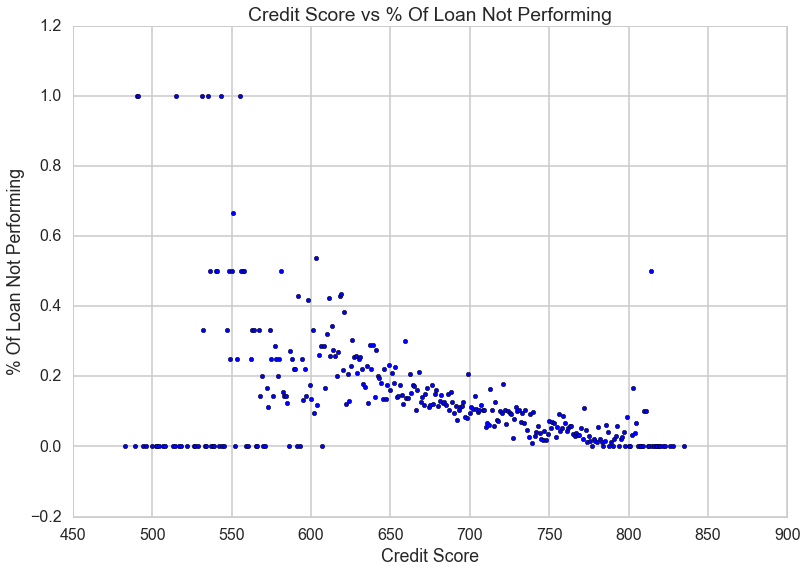

In [27]:
df1=dfWithG[['LOAN SEQUENCE NUMBER','CREDIT SCORE','CURRENT LOAN DELINQUENCY STATUS']]
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df2['PERFORMING']=[0 if x==0 else 1 for x in df2['CURRENT LOAN DELINQUENCY STATUS']]
df3=df2.reset_index()
df3=df3[['CREDIT SCORE','PERFORMING']]
df3=df3.groupby('CREDIT SCORE').mean()
df3=df3.reset_index()
plt.scatter(df3['CREDIT SCORE'],df3['PERFORMING'])
plt.xlabel('Credit Score')
plt.ylabel('% Of Loan Not Performing')
plt.title('Credit Score vs % Of Loan Not Performing')
plt.xlim(400,850)
plt.autoscale()

#### Combined Loan to Value Ratio (LTV) VS NON PERFORMING LOAN correlation

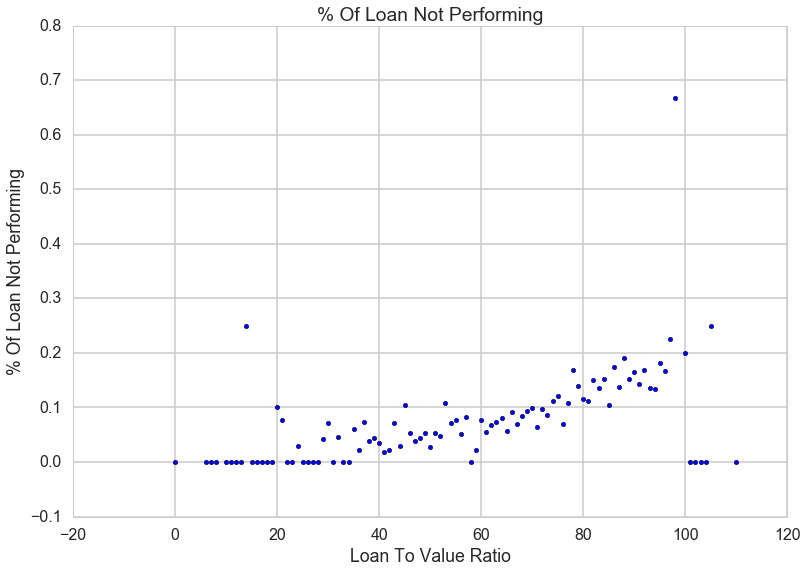

In [28]:
df1=dfWithG[['LOAN SEQUENCE NUMBER','CLTV','CURRENT LOAN DELINQUENCY STATUS']]
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df2['PERFORMING']=[0 if x==0 else 1 for x in df2['CURRENT LOAN DELINQUENCY STATUS']]
df3=df2.reset_index()
df3=df3[['CLTV','PERFORMING']]
df3=df3.groupby('CLTV').mean()
df3=df3.reset_index()
plt.scatter(df3['CLTV'],df3['PERFORMING'])
plt.xlabel('Loan To Value Ratio')
plt.ylabel('% Of Loan Not Performing')
plt.title('% Of Loan Not Performing')

plt.autoscale()



#### INTEREST RATES VS NON PERFORMING LOAN correlation

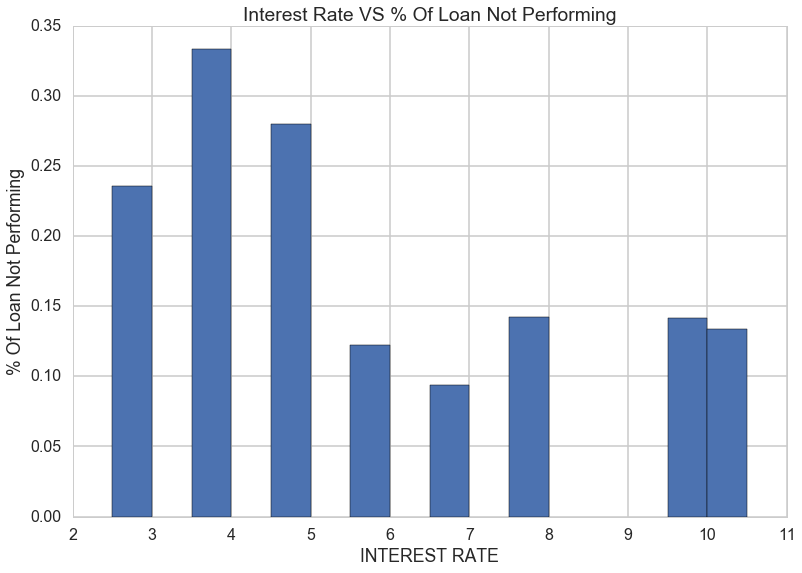

In [29]:

df1=dfWithG[['LOAN SEQUENCE NUMBER','CURRENT INTEREST RATE','CURRENT LOAN DELINQUENCY STATUS']]
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df2['PERFORMING']=[0 if x==0 else 1 for x in df2['CURRENT LOAN DELINQUENCY STATUS']]
df3=df2.reset_index()
df3=df3[['CURRENT INTEREST RATE','PERFORMING']]
df3['CURRENT INTEREST RATE']=df3['CURRENT INTEREST RATE'].apply(groupInterestRate);
df4=df3.groupby('CURRENT INTEREST RATE',sort=True).mean()
df4=df4.reset_index()
plt.bar(df4['CURRENT INTEREST RATE'],df4['PERFORMING'],width=0.5)
plt.xlabel('INTEREST RATE')
plt.ylabel('% Of Loan Not Performing')
plt.title('Interest Rate VS % Of Loan Not Performing')
plt.xlim(1,9)
plt.autoscale()

#### DEBT TO INCOME RATIO (DTI) VS NON PERFORMING LOAN correlation

(1, 80)

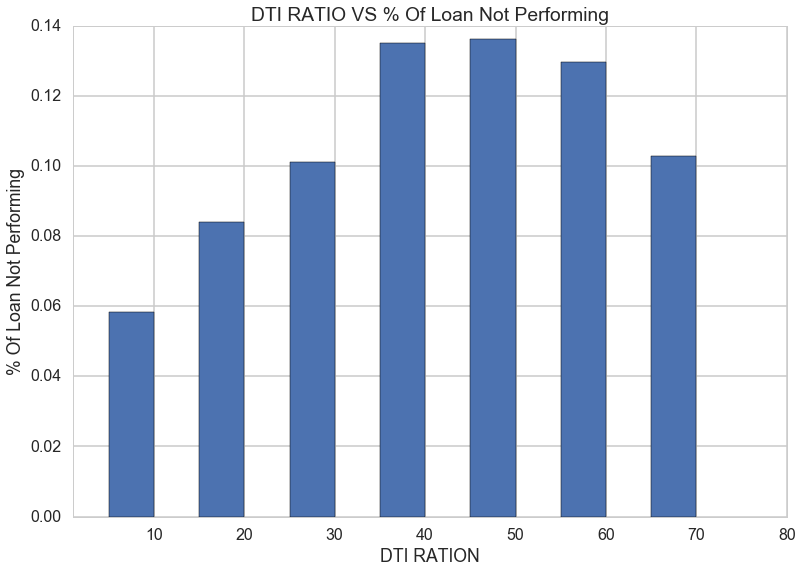

In [30]:
df1=dfWithG[['LOAN SEQUENCE NUMBER','DTI Ratio','CURRENT LOAN DELINQUENCY STATUS']]
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df2['PERFORMING']=[0 if x==0 else 1 for x in df2['CURRENT LOAN DELINQUENCY STATUS']]
df3=df2.reset_index()
df3=df3[['DTI Ratio','PERFORMING']]
df3['DTI Ratio']=df3['DTI Ratio'].apply(groupDTIRatio);
df4=df3.groupby('DTI Ratio',sort=True).mean()
df4=df4.reset_index()
plt.bar(df4['DTI Ratio'],df4['PERFORMING'],width=5)
plt.xlabel('DTI RATION')
plt.ylabel('% Of Loan Not Performing')
plt.title('DTI RATIO VS % Of Loan Not Performing')
plt.xlim(1,80)
#plt.autoscale()

#### Mondification Flag and LOAN DELINQUENCY STATUS relationship

15684
28
15656


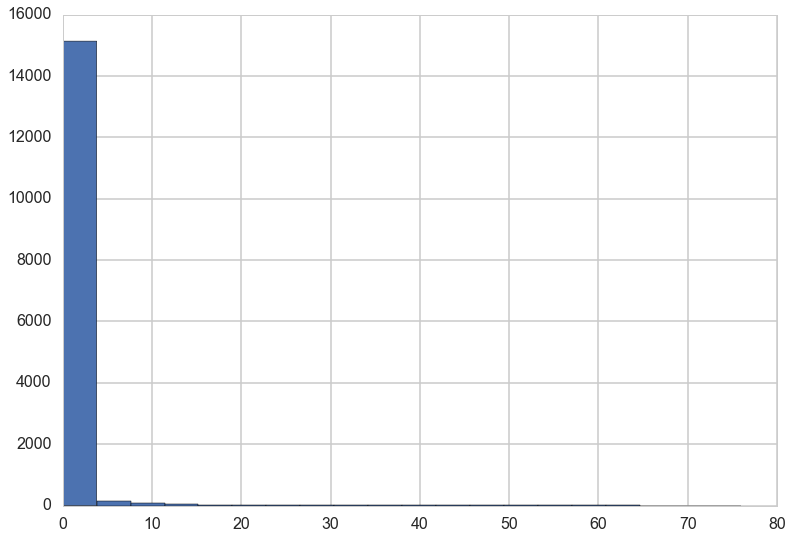

In [31]:
df1=dfWithG[['LOAN SEQUENCE NUMBER','MODIFICATION FLAG','CURRENT LOAN DELINQUENCY STATUS']]
#df1=df1[df1['MODIFICATION FLAG']=='N']
df2=df1.groupby('LOAN SEQUENCE NUMBER').max().reset_index()
df3=df2[['MODIFICATION FLAG','CURRENT LOAN DELINQUENCY STATUS']]
print (len(df3))
df4=df3[df3['MODIFICATION FLAG']=='Y']
print (len(df4))
df5=df3[df3['MODIFICATION FLAG']=='N']
print (len(df5))
plt.hist(df5['CURRENT LOAN DELINQUENCY STATUS'],20)
plt.autoscale()

## Checking the Correlation between features 
       We use graph ploting and correlation matrix to make sure there is no high correlation between the features.

In [32]:
def groupCreditScore(var):
    if 299< var <600:
        return 450
    if 599< var <650:
        return 625
    if 649< var <700:
        return 675
    if 699< var <750:
        return 725
    if 749< var <800:
        return 775
    else:
        return 825
        

#### Credit Scrore and Current interest rate

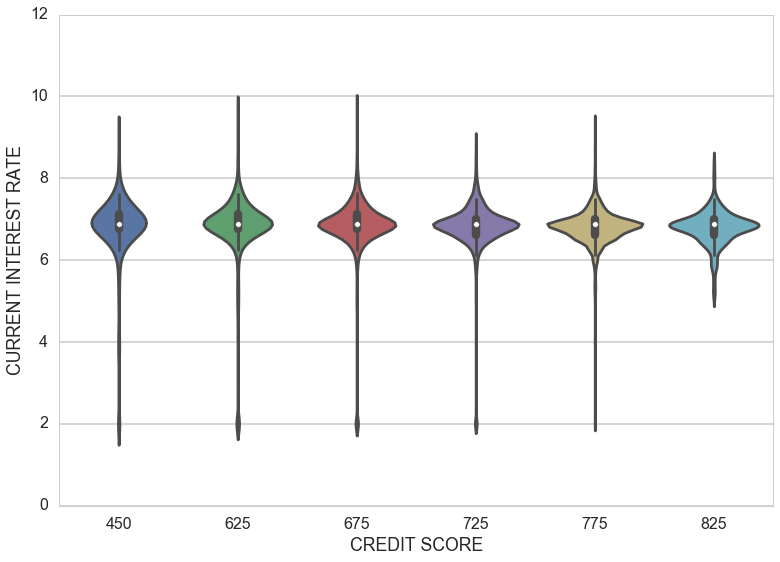

In [33]:

df1=dfWithG[['LOAN SEQUENCE NUMBER','CREDIT SCORE','CURRENT INTEREST RATE','year','quarter']]
df1=df1[(df1['year']==2013) & (df1['quarter']==4)]
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df3=df2.reset_index()
df3=df3[['CREDIT SCORE','CURRENT INTEREST RATE']]
df3['CREDIT SCORE']=df3['CREDIT SCORE'].apply(groupCreditScore);
df3
sns.violinplot(x="CREDIT SCORE", y="CURRENT INTEREST RATE", data=df3)

#### Relation between CREDIT SCORE  and LOAN TO VALUE Ratio

In [34]:
df1=dfWithG[['LOAN SEQUENCE NUMBER','CREDIT SCORE','CLTV','year','quarter']]
df1=df1[(df1['year']==2013) & (df1['quarter']==4)]
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df3=df2.reset_index()
df3=df3[['CREDIT SCORE','CLTV']]
df4=df3.groupby('CREDIT SCORE').median().reset_index()
df4.corr(method='pearson')

,CREDIT SCORE,CLTV
CREDIT SCORE,1.000000,-0.391254
CLTV,-0.391254,1.000000


#### Relation between CREDIT SCORE  and DEBT TO INCOME Ratio

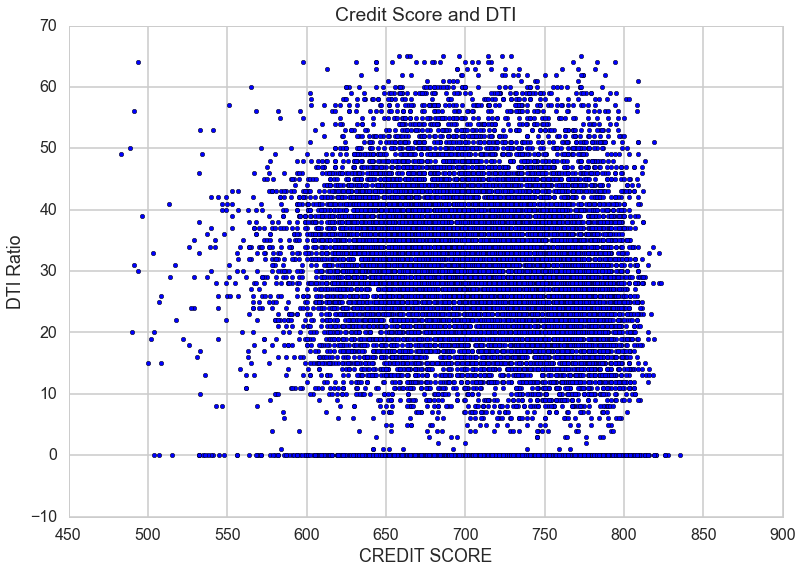

In [35]:
df1=dfWithG[['LOAN SEQUENCE NUMBER','CREDIT SCORE','DTI Ratio','year','quarter']]
df1=df1[(df1['year']==2013) & (df1['quarter']==4)]
df2=df1.groupby('LOAN SEQUENCE NUMBER').max()
df3=df2.reset_index()
#df3=df3.sample(frac=0.01)
plt.scatter(df3['CREDIT SCORE'],df3['DTI Ratio'])
plt.xlabel('CREDIT SCORE')
plt.ylabel('DTI Ratio')
plt.title('Credit Score and DTI')
plt.xlim(400,850)
plt.autoscale()

#### The above anayalsis show weak correlation between the above features

##  Training Logistic Regression Model
    Our aim is to find if given loan will default or find Non Performing Loan